# Solnet: Open-source deep learning models for global PV power forecasting

## Imports

In [1]:
import torch
import requests
import requests_cache
import io
import json
import openmeteo_requests

import pandas as pd
import numpy as np

from retry_requests import retry
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

# Sklearn does not have an MBE metric so we create one here
def mbe(x, y):
    mbe = np.mean(np.subtract(x, y))
    return mbe

## Parameters

First we have to specify all the parameters required to gather our data and run our models.

In [2]:
# In here we specify all the parameters needed for a run:

# Data fetching
latitude =-33.7177
longitude = 151.1152
optimal_angles = 1                                                                    # 1 if azimuth and tilt are not known, otherwise 0
azimuth = None                                                                        # None if azimuth is not known
tilt = None                                                                           # None if tilt is not known
peak_power = 2.48                                                                     # The peak output of the system
loss = 14                                                                             # The percentage system loss; PVGIS takes 14% as baseline

# Forecasting parameters
target = 'P'                                                                          # PV Power
past_features = ['P']                                                                 # Lagged PV power
future_features = ['hour_sin',                                                        #
                   'hour_cos',
                   'relative_humidity_2m',
                   'diffuse_radiation',
                   'direct_radiation']
feat_count = len(past_features) + len(future_features)

lags = 24                                                                             # How many lags we want to use in our model
forecast_period = 24                                                                  # How many hours we want to forecast
gap = 0                                                                               # Wether or not there is a gap between the time the forecast is made and the first hour to forecast
forecast_gap = 0                                                                      # Wether or not there is a gap between the forecasts (for example only every other day: 24)

# Lstm parameters
hidden_size = 200                                                                     # Size of the hidden state
num_layers = 3                                                                        # Number of layers in our LSTM
dropout = 0.5                                                                         # Dropout percentage for training, avoids overfitting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")                 # Cuda device, if enabled

# Training parameters
epochs = 100                                                                           # Number of loops through the entire dataset
batch_size = 32                                                                       # Number of samples processed per forward and backward pass
learning_rate = 0.001                                                                 # The parameter specifying the step size of the update after each backwards pass

# Model
model_name = 'Sydney_1'                                                               # The name attached to the model

## Gather data

### PV data

First we need synthetic PV data to create our source model which is the starting point for transfer learning. For this, we use PVGIS, an open source tool which provides PV data for any land based location on earth.

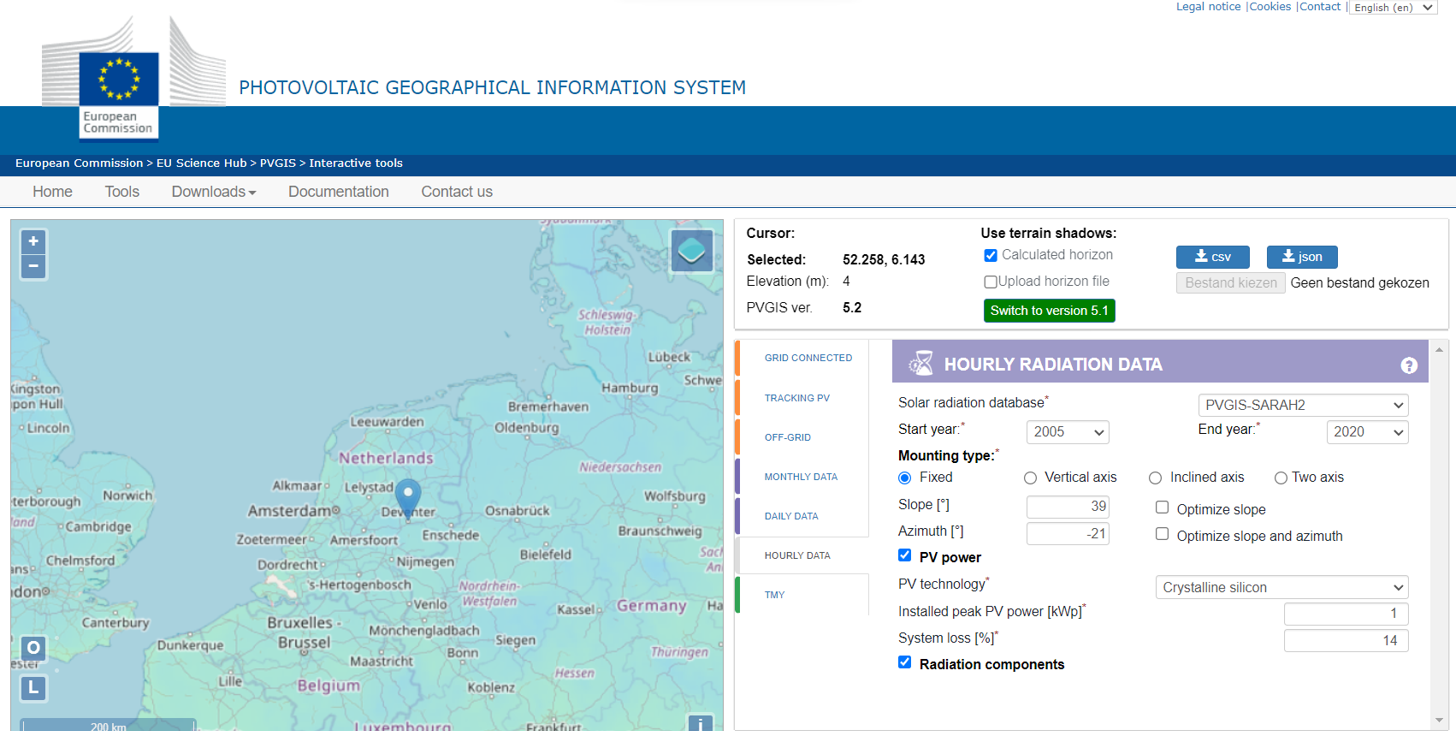

In [3]:
def get_pvgis_hourly(parameters:dict):
      """
      Fetch the data from PVGIS
      :param parameters: The parameters of the PV system, specified by the user
      :return: a dataframe holding the hourly PVGIS data
      """

      URL = 'https://re.jrc.ec.europa.eu/api/v5_2/seriescalc'

      data_request = requests.get(URL,
                                  params=parameters,
                                  timeout=120)

      if not data_request.ok:
          try:
              err_msg = data_request.json()
          except Exception:
              data_request.raise_for_status()
          else:
              raise requests.HTTPError(err_msg['message'])

      filename = io.StringIO(data_request.text)
      try:
          src = json.load(filename)
      except AttributeError:  # str/path has no .read() attribute
          with open(str(filename), 'r') as fbuf:
              src = json.load(fbuf)

      data = pd.DataFrame(src['outputs']['hourly'])
      data.index = pd.to_datetime(data['time'], format='%Y%m%d:%H%M', utc=True)
      data = data.drop('time', axis=1)
      data = data.astype(dtype={'Int': 'int'})

      return data

In [4]:
start_date = 2005                                                                     # Start the data in 2005, the earliest moment for PVGIS
end_date = 2011                                                                       # None means 2023, the last moment for PVGIS (as of 2025)

parameters_PVGIS = {'lat': latitude,
              'lon': longitude,
              'startyear': start_date,
              'endyear': end_date,
              'outputformat': 'json',
              'angle': tilt,
              'aspect': azimuth,
              'optimalangles': optimal_angles,
              'pvcalculation': 1,
              'components': 1,
              'peakpower': peak_power,
              'loss': loss,
              'localtime': 0}

In [5]:
pv_data = get_pvgis_hourly(parameters_PVGIS)[['P']]
pv_data.head(5)

,P
time,
2005-01-01 00:30:00+00:00,1701.08
2005-01-01 01:30:00+00:00,1687.37
2005-01-01 02:30:00+00:00,1667.68
2005-01-01 03:30:00+00:00,1640.99
2005-01-01 04:30:00+00:00,1356.56


In [6]:
pv_data.index = pv_data.index.tz_convert("Australia/Sydney").tz_localize(None)
pv_data.index = pv_data.index.floor('h')
pv_data = pv_data[13:-11]

### Cyclical features

We can add information on the hour of the day (or any other time related feature) to help improve the forecasting performance of our model. There are several ways to do this but the best way is to use cyclical encoding using a sine and cosine function.

In [18]:
pv_data.loc[:, 'hour_sin'] = np.sin(2 * np.pi * pv_data.index.hour / 24)
pv_data.loc[:, 'hour_cos'] = np.cos(2 * np.pi * pv_data.index.hour / 24)

There are two advantages in using this method:
1. We limit the number of additional features (versus using dummy variables)
2. We retain the information within the hours (i.e. 23 is very close to 0) (versus using a single variable with the hours themselves)

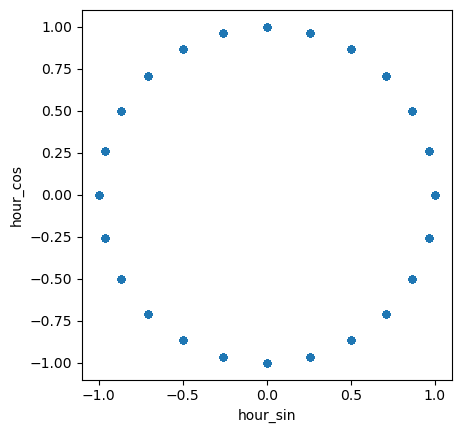

In [19]:
pv_data.plot.scatter('hour_sin','hour_cos').set_aspect('equal')

### Weather data

Next we need weather data to improve the forecasting performance of our model.

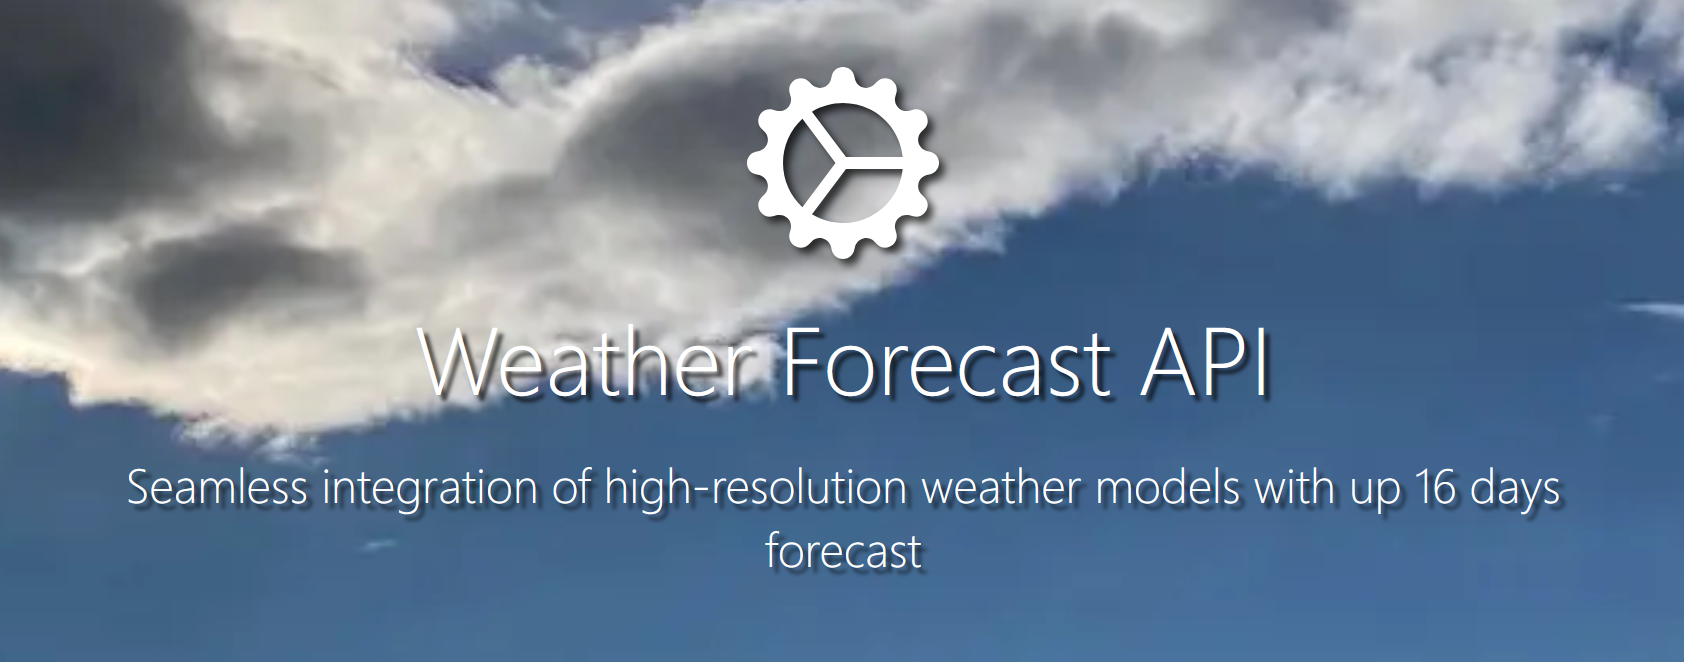

In [20]:
def get_open_meteo_hourly(parameters):

    URL = "https://archive-api.open-meteo.com/v1/archive"

    # Set up the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    open_meteo = openmeteo_requests.Client(session=retry_session)

    responses = open_meteo.weather_api(URL, params=parameters)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_relative_humidity_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_direct_radiation = hourly.Variables(1).ValuesAsNumpy()
    hourly_diffuse_radiation = hourly.Variables(2).ValuesAsNumpy()
    date = pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left")

    hourly_data = {"date": date,
                    "relative_humidity_2m": hourly_relative_humidity_2m,
                    "direct_radiation": hourly_direct_radiation,
                    "diffuse_radiation": hourly_diffuse_radiation}

    hourly_dataframe = pd.DataFrame(data=hourly_data)

    return hourly_dataframe

In [21]:
parameters_open_meteo = {"latitude": latitude,
                         "longitude": longitude,
                         "start_date": pv_data.index[0].date() - pd.Timedelta(days=1),
                         "end_date": pv_data.index[-1].date(),
                         "hourly": ["relative_humidity_2m",
                                    "direct_radiation",
                                    "diffuse_radiation"],
                         "models": "best_match"}

In [22]:
weather_data = get_open_meteo_hourly(parameters_open_meteo)

Coordinates -33.70825958251953°N 151.15528869628906°E
Elevation 202.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


In [23]:
weather_data.head(5)

,date,relative_humidity_2m,direct_radiation,diffuse_radiation
0,2005-01-01 00:00:00+00:00,42.433678,594.0,232.0
1,2005-01-01 01:00:00+00:00,34.765125,583.0,326.0
2,2005-01-01 02:00:00+00:00,30.755770,596.0,348.0
3,2005-01-01 03:00:00+00:00,29.143631,601.0,359.0
4,2005-01-01 04:00:00+00:00,28.109303,667.0,269.0


In [24]:
weather_data.set_index('date', inplace=True)
weather_data.index = weather_data.index.tz_convert("Australia/Sydney").tz_localize(None)
weather_data = weather_data[13:-11]
training_data = pd.concat([pv_data, weather_data], axis=1)
training_data.head(5)

,P,hour_sin,hour_cos,relative_humidity_2m,direct_radiation,diffuse_radiation
2005-01-02 00:00:00,0.0,0.000000,1.000000,50.054710,0.0,0.0
2005-01-02 01:00:00,0.0,0.258819,0.965926,49.470650,0.0,0.0
2005-01-02 02:00:00,0.0,0.500000,0.866025,56.487614,0.0,0.0
2005-01-02 03:00:00,0.0,0.707107,0.707107,66.564323,0.0,0.0
2005-01-02 04:00:00,0.0,0.866025,0.500000,81.239319,0.0,0.0


In [25]:
training_data = training_data[~training_data.index.duplicated(keep="first")]

In [29]:
full_range = pd.date_range(start=training_data.index[0], end=training_data.index[-1], freq="h")
training_data = training_data.reindex(full_range)
training_data = training_data.ffill()

## Tensors

In [30]:
def _moving_window(array, windows, window_size, window_step):
    """
    Create a moving window based on the steps that we want to forecast
    :param array: the flat array
    :param window_size: the N timesteps that we want to include in each window
    :param window_step: the step size
    :return: an array with dimensions taking the moving window into account
    """
    # Create an array of starting indices for each window
    start_indices = np.arange(0, windows * window_step, window_step)
    # Fill the array from the start index onwards
    index_array = start_indices[:, np.newaxis] + np.arange(window_size)
    # Apply the indexing on the original array
    return array[index_array]


def _scale(train, test, domain_min=None, domain_max=None):
    """
    MinMax scaling, fitting and transforming the train set, transforming the test set (with the train set fit)
    :param train: the train tensor
    :param test: the test tensor
    :param domain_min: a domain minimum (if known, otherwise it's based on the train.min())
    :param domain_max: a domain maximum (if known, otherwise it's based on the train.max())
    :return: returns the scaled train and test sets
    """
    minimum = domain_min if domain_min is not None else train.min()
    maximum = domain_max if domain_max is not None else train.max()

    denominator = maximum - minimum or 1e-8

    train = (train - minimum) / denominator
    test = (test - minimum) / denominator

    return train, test

In [31]:
class Tensors:
    def __init__(self,
                 data,
                 target: str,
                 past_features: list,
                 future_features: list,
                 lags: int,
                 forecast_period: int,
                 gap: int = 0,
                 forecast_gap: int = 0,
                 train_test_split: float = 0.8,
                 domain_min=None,
                 domain_max=None):
        """
        create tensors for use in pytorch
        :param data: the data (Pandas Dataframe)
        :param target: the target variable name
        :param past_features: A list of PAST feature names
        :param future_features: A list of FUTURE feature names
        :param lags: The number of lags to include (the input length)
        :param forecast_period: the number of hours to forecast
        :param gap: the gap between the lags and the forecast period
        :param forecast_gap: the gap between each forecast, can be negative
        :param train_test_split: the train test split as a float
        :param domain_min: a domain minimum (if known, otherwise train.min())
        :param domain_max: a domain maximum (if known, otherwise train.max())
        """

        self.data = data
        self.target = target
        self.past_features = past_features
        self.future_features = future_features
        self.lags = lags
        self.forecast_period = forecast_period
        self.gap = gap
        self.forecast_gap = forecast_gap
        self.train_test_split = train_test_split
        self.domain_min = domain_min
        self.domain_max = domain_max

    def create_tensor(self):
        """
        The method doing the tensor creation
        :return: tensors, split in a train and test set
        """

        start = self.lags + self.gap
        prediction_length = len(self.data) - start                                    # we can't forecast the first [lags] + [gap] timesteps
        divider = self.forecast_gap + self.forecast_period                            # The number of predictions is based on the forecast gap + forecast length

        # Check if the array is of the correct length
        left_over = prediction_length % divider
        if left_over:
            self.data = self.data[left_over:]
            prediction_length = len(self.data) - self.lags - self.gap

        predictions = (prediction_length - self.forecast_period) // divider + 1       # The number of samples

        train_len = round(predictions * self.train_test_split)
        test_len = predictions - train_len

        # Storage
        max_len = max(self.forecast_period, self.lags)
        feat_count = len(self.past_features) + len(self.future_features)

        X_train = torch.zeros(train_len, max_len, feat_count)                         # The dimensions of our X_Train tensor (Samples, period, features)
        X_test = torch.zeros(test_len, max_len, feat_count)                           # The dimensions of our X_Test tensor (Samples, period, features)

        # |Past features|
        for i, feat in enumerate(self.past_features):
            pad_left = max(0, self.forecast_period - self.lags)                       # Padding in case lags and forecast period are of different length
            train, test = self._feature_block(self.data[feat],                        # Take the correct slice of data and apply a moving window and scaling
                                              train_len,
                                              test_len,
                                              self.lags,
                                              divider,
                                              pad_left=pad_left,
                                              idx=i)
            X_train[:, :, i] = train                                                  # Inpute the feature in our overall tensor
            X_test[:, :, i] = test

        # |Future features|                                                           # Identical to the past features
        for j, feat in enumerate(self.future_features):
            pad_left = max(0, self.lags - self.forecast_period)
            train, test = self._feature_block(self.data[feat][start:],
                                              train_len,
                                              test_len,
                                              self.forecast_period,
                                              divider,
                                              pad_left=pad_left,
                                              idx=len(self.past_features) + j)
            X_train[:, :, len(self.past_features) + j] = train
            X_test[:, :, len(self.past_features) + j] = test

        # --- Target ---
        y_train, y_test = self._feature_block(self.data[self.target][start:],
                                              train_len,
                                              test_len,
                                              self.forecast_period,
                                              divider,
                                              idx=0)

        return X_train, X_test, y_train, y_test

    def _feature_block(self,
                       arr,
                       train_len,
                       test_len,
                       win_len,
                       divider,
                       pad_left=0,
                       pad_right=0,
                       idx=None):
        """
        Handles moving window, padding, scaling, and tensor conversion.
        :param arr: the current feature array
        :param train_len: the number of train samples
        :param test_len: the number of test samples
        :param win_len: number of lags or number of forecast period steps
        :param divider: To go from a flat to a correctly dimensioned array
        :param pad_left: padding in case the lags != forecast period
        :param pad_right: in case padding is done after the original array
        :param indx: The id of the feature, required for scaling
        """

        # Train/test slices
        train = np.array(arr[0: (train_len - 1) * divider + win_len])                 # The flat train array
        test = np.array(arr[(train_len * divider):
        (train_len + test_len) * divider + win_len])                                  # The flat test array

        # Reshape
        train = _moving_window(train, train_len, win_len, divider)                    # Obtain the correctly dimensioned train array
        test = _moving_window(test, test_len, win_len, divider)                       # Obtain the correctly dimensioned test array

        # Padding if mismatch between lags vs forecast
        if pad_left or pad_right:
            train = np.pad(train, ((0, 0), (pad_left, pad_right)))
            test = np.pad(test, ((0, 0), (pad_left, pad_right)))

        # Scaling based on domain knowledge, if available
        dmin = self.domain_min[idx] if isinstance(self.domain_min, list) else None
        dmax = self.domain_max[idx] if isinstance(self.domain_max, list) else None
        train, test = _scale(train, test, domain_min=dmin, domain_max=dmax)

        return torch.tensor(train, dtype=torch.float32), torch.tensor(test, dtype=torch.float32)

In [32]:
# Get the data in the torch.tensor format
target_tensors = Tensors(training_data,
                         'P',
                         past_features ,
                         future_features,
                         lags,
                         forecast_period,
                         gap=gap,
                         forecast_gap=forecast_gap)

# Split the data into train and test sets with separate tensors for features (X) and the target (y)
X_train, X_test, y_train, y_test = target_tensors.create_tensor()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2043, 24, 6]),
 torch.Size([511, 24, 6]),
 torch.Size([2043, 24]),
 torch.Size([511, 24]))

In [30]:
training_data.index

DatetimeIndex(['2005-01-02 00:00:00', '2005-01-02 01:00:00',
               '2005-01-02 02:00:00', '2005-01-02 03:00:00',
               '2005-01-02 04:00:00', '2005-01-02 05:00:00',
               '2005-01-02 06:00:00', '2005-01-02 07:00:00',
               '2005-01-02 08:00:00', '2005-01-02 09:00:00',
               ...
               '2011-12-31 14:00:00', '2011-12-31 15:00:00',
               '2011-12-31 16:00:00', '2011-12-31 17:00:00',
               '2011-12-31 18:00:00', '2011-12-31 19:00:00',
               '2011-12-31 20:00:00', '2011-12-31 21:00:00',
               '2011-12-31 22:00:00', '2011-12-31 23:00:00'],
              dtype='datetime64[ns]', length=61320, freq=None)

In [17]:
X_cal = X_train[-X_test.shape[0]:,:,:]
X_train = X_train[:-X_test.shape[0],:,:]
y_cal = y_train[-y_test.shape[0]:,:]
y_train = y_train[:-y_test.shape[0],:]

X_train.shape, X_cal.shape, X_test.shape, y_train.shape, y_cal.shape, y_test.shape

(torch.Size([1532, 24, 6]),
 torch.Size([511, 24, 6]),
 torch.Size([511, 24, 6]),
 torch.Size([1532, 24]),
 torch.Size([511, 24]),
 torch.Size([511, 24]))

## Create source model

In [18]:
class LSTM(nn.Module):
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            output_size,
            dropout):
        """
        Simple LSTM model made in pytorch
        :param input_size: the size of the input (based on the lags provided)
        :param hidden_size: the hidden layer sizes
        :param num_layers: the number of layers in the LSTM (each of size hidden_size)
        :param output_size: the forecast window (f.e. 24 means 'forecast 24 hours')
        :param dropout: the dropout parameter used for training, to avoid overfitting
        """
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.dropout = dropout

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_size, out_features=output_size)

    def forward(self, input):
        """
        Forward method for the LSTM layer. I.e. how input gets processed
        :param input: the input tensor
        :return: output tensor
        """
        hidden, _ = self.lstm(input, None)
        if hidden.dim() == 2:
            hidden = hidden[-1, :]
        else:
            hidden = hidden[:, -1, :]
        output = self.linear(hidden)

        return output

class Training:

    def __init__(
            self,
            model,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs,
            batch_size=32,
            learning_rate=0.001,
            criterion=torch.nn.MSELoss()):
        """
        The training class for the pytorch model
        :param model: The model that we train
        :param X_train: the tensor with training values for X
        :param y_train: the tensor with training values for y
        :param X_test: the tensor with test values for X
        :param y_test: the tensor with test values for y
        :param epochs: the number of epochs that we wish to train for
        :param batch_size: the batch size before going through backpropagation
        :param learning_rate: the learning rate
        :param criterion: the criterion by which to evaluate the performance
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        train_data = TensorDataset(X_train.to(self.device), y_train.to(self.device))
        test_data = TensorDataset(X_test.to(self.device), y_test.to(self.device))
        self.train_loader = DataLoader(train_data, batch_size=batch_size)
        self.test_loader = DataLoader(test_data, batch_size=batch_size)

        self.model = model
        self.criterion = criterion
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.epochs = epochs

    def fit(self, verbose=False):
        """
        The training loop itself
        :return: state_dict_list: the state dictionary for each of the epochs, argmin_test: the best epoch
        """
        avg_train_error = []
        avg_test_error = []
        state_dict_list = []

        for epoch in range(self.epochs):
            num_train_batches = 0
            num_test_batches = 0
            total_loss = 0
            total_loss_test = 0
            batches = iter(self.train_loader)
            self.model.train()

            # Do a forward and backwards pass for every batch
            for input, output in batches:
                prediction = self.model(input)                                            # Prediction based on current model
                output = output.squeeze()                                                 # The correct values
                loss = self.criterion(prediction, output)                                 # Evaluate prediction

                total_loss += float(loss.detach())
                num_train_batches += 1

                self.optimizer.zero_grad()
                loss.backward()                                                           # Take a backwards step based on the current batch
                self.optimizer.step()                                                     # Update the state dictionary

            self.model.eval()                                                             # Now evaluate the performance on the test set

            with torch.inference_mode():

                test_batches = iter(self.test_loader)

                for input, output in test_batches:
                    prediction = self.model(input)
                    output = output.squeeze()
                    test_loss = self.criterion(prediction, output)

                    total_loss_test += float(test_loss.detach())
                    num_test_batches += 1

            avg_train_error.append(total_loss / num_train_batches)
            avg_test_error.append(total_loss_test / num_test_batches)

            state_dict_list.append(self.model.state_dict())

            if epoch % 5 == 0:
                print('Step {}: Average train loss: {:.4f} | Average test loss: {:.4f}'.format(epoch,
                                                                                               avg_train_error[epoch],
                                                                                               avg_test_error[epoch]))

        argmin_test = avg_test_error.index(min(avg_test_error))

        print('Best Epoch: ' + str(argmin_test))

        if verbose:
            plt.plot(avg_train_error, label='train error')
            plt.plot(avg_test_error, label='test error')
            plt.legend()

        return state_dict_list, argmin_test

In [19]:
# Create a source model
source_model  = LSTM(feat_count,
                     hidden_size,
                     num_layers,
                     forecast_period,
                     dropout).to(device)

Step 0: Average train loss: 0.0272 | Average test loss: 0.0210
Step 5: Average train loss: 0.0027 | Average test loss: 0.0023
Step 10: Average train loss: 0.0025 | Average test loss: 0.0032
Step 15: Average train loss: 0.0026 | Average test loss: 0.0029
Step 20: Average train loss: 0.0025 | Average test loss: 0.0016
Step 25: Average train loss: 0.0022 | Average test loss: 0.0016
Step 30: Average train loss: 0.0020 | Average test loss: 0.0016
Step 35: Average train loss: 0.0019 | Average test loss: 0.0015
Step 40: Average train loss: 0.0027 | Average test loss: 0.0034
Step 45: Average train loss: 0.0020 | Average test loss: 0.0013
Step 50: Average train loss: 0.0024 | Average test loss: 0.0022
Step 55: Average train loss: 0.0017 | Average test loss: 0.0011
Step 60: Average train loss: 0.0016 | Average test loss: 0.0011
Step 65: Average train loss: 0.0021 | Average test loss: 0.0022
Step 70: Average train loss: 0.0015 | Average test loss: 0.0013
Step 75: Average train loss: 0.0012 | Aver

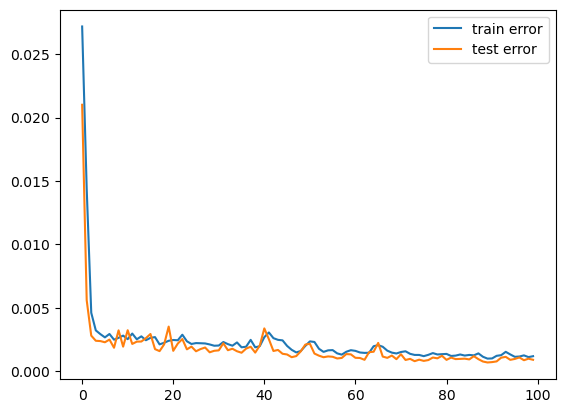

In [20]:
# Initialize the trainer
training = Training(source_model,
                    X_train,                                                              # We train this model on the source data only
                    y_train,
                    X_cal,
                    y_cal,
                    epochs,
                    batch_size=batch_size,
                    learning_rate=learning_rate)

# Train the model and return the trained parameters and the best iteration
state_dict_list_source, best_epoch_source = training.fit(verbose=True)

In [21]:
# Load the state dictionary of the best performing model
source_model.load_state_dict(state_dict_list_source[best_epoch_source])

<All keys matched successfully>

In [23]:
# Forecast with the model
forecasts = source_model(X_cal.to(device)).cpu().detach().flatten().numpy()

# Evaluate the model performance
mse(y_test.detach().flatten().numpy(), forecasts)

0.03270697221159935

In [25]:
source_model(X_cal.to(device)).cpu().detach().numpy()

array([[-1.68606639e-04, -1.78140309e-03, -2.35793460e-03, ...,
         4.10538167e-04,  6.61192555e-03,  1.03749614e-03],
       [-1.75732747e-03, -3.55172902e-03, -3.10809631e-03, ...,
        -1.46161765e-05,  1.03379441e-02,  3.18597909e-03],
       [-1.75649673e-03, -3.30075622e-03, -3.02511547e-03, ...,
         1.92299485e-05,  1.04121221e-02,  2.96824332e-03],
       ...,
       [-3.66795808e-04, -3.02623305e-03, -5.04794531e-03, ...,
         2.88788974e-03,  1.09390682e-02,  1.97189953e-03],
       [-1.11000612e-03, -3.12293693e-03, -6.31737243e-03, ...,
         2.57176347e-03,  1.24242483e-02,  3.12274415e-03],
       [-1.46831945e-03, -2.80711334e-03, -5.43530844e-03, ...,
         1.60618499e-03,  1.16310967e-02,  2.55819969e-03]],
      shape=(511, 24), dtype=float32)

In [37]:
training_data

,P,hour_sin,hour_cos,relative_humidity_2m,direct_radiation,diffuse_radiation
2005-01-02 00:00:00,0.00,0.000000,1.000000,50.054710,0.0,0.0
2005-01-02 01:00:00,0.00,0.258819,0.965926,49.470650,0.0,0.0
2005-01-02 02:00:00,0.00,0.500000,0.866025,56.487614,0.0,0.0
2005-01-02 03:00:00,0.00,0.707107,0.707107,66.564323,0.0,0.0
2005-01-02 04:00:00,0.00,0.866025,0.500000,81.239319,0.0,0.0
...,...,...,...,...,...,...
2011-12-31 19:00:00,84.64,-0.965926,0.258819,62.379166,103.0,82.0
2011-12-31 20:00:00,0.00,-0.866025,0.500000,65.764854,44.0,31.0
2011-12-31 21:00:00,0.00,-0.707107,0.707107,68.904320,0.0,0.0
2011-12-31 22:00:00,0.00,-0.500000,0.866025,71.330650,0.0,0.0
